In [7]:
from sklearn import datasets

X, y = datasets.load_iris(return_X_y=True, as_frame=True)
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [8]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [35]:
class Model(nn.Module):
  def __init__(self, input_dim):
    super(Model, self).__init__()
    self.layer1 = nn.Linear(input_dim, 50)
    self.layer2 = nn.Linear(50, 50)
    self.layer3 = nn.Linear(50, 3)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = F.softmax(self.layer3(x), dim=-1)
    return x

In [48]:
train_dataset = TensorDataset(torch.tensor(X_train_scaled).float(), torch.tensor(y_train.to_numpy()).float())
test_dataset = TensorDataset(torch.tensor(X_test_scaled), torch.tensor(y_test.to_numpy()).float())

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=16)

next(iter(train_dataloader))

[tensor([[-0.3673, -1.2604,  0.0221, -0.1925],
         [-1.2315,  0.0900, -1.3610, -1.3945],
         [ 0.7438,  0.3151,  0.7136,  1.0095],
         [ 0.3735, -0.3601,  0.2526,  0.0746],
         [-0.8611, -0.8103,  0.0221,  0.2081],
         [-0.1204, -0.8103,  0.1373, -0.3261],
         [-1.1080, -1.7106, -0.3237, -0.3261],
         [-1.1080,  0.9903, -1.3034, -0.8603],
         [ 0.7438, -0.1350,  0.9442,  0.7423],
         [ 0.3735,  0.7653,  0.8865,  1.4101],
         [ 0.9908,  0.0900,  0.4831,  0.3417],
         [-0.6142,  1.4405, -1.3610, -1.3945],
         [-0.6142, -0.1350,  0.3679,  0.3417],
         [-1.2315, -0.1350, -1.4186, -1.3945],
         [ 0.6204,  0.0900,  0.9442,  0.7423],
         [-0.2438,  1.6656, -1.2458, -1.2610]]),
 tensor([1., 0., 2., 1., 1., 1., 1., 0., 2., 2., 1., 0., 1., 0., 2., 0.])]

In [49]:
model = Model(X_train_scaled.shape[1])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

In [50]:
import numpy as np

EPOCHS = 100
loss_list = np.zeros(EPOCHS)
accuracy_list = np.zeros(EPOCHS)
for i in range(EPOCHS):
  total_loss = 0
  acc = 0
  for inputs, targets in train_dataloader:
    preds = model(inputs)
    loss = loss_fn(preds, targets.long())
    total_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_list[i] = total_loss / len(train_dataloader)

  for test_batch, target_batch in test_dataloader:
    with torch.no_grad():
      preds = model(inputs)
      correct = (torch.argmax(preds, dim=-1) == targets).type(torch.FloatTensor)
      acc +=  correct.mean()
  accuracy_list[i] = acc / len(test_dataloader)

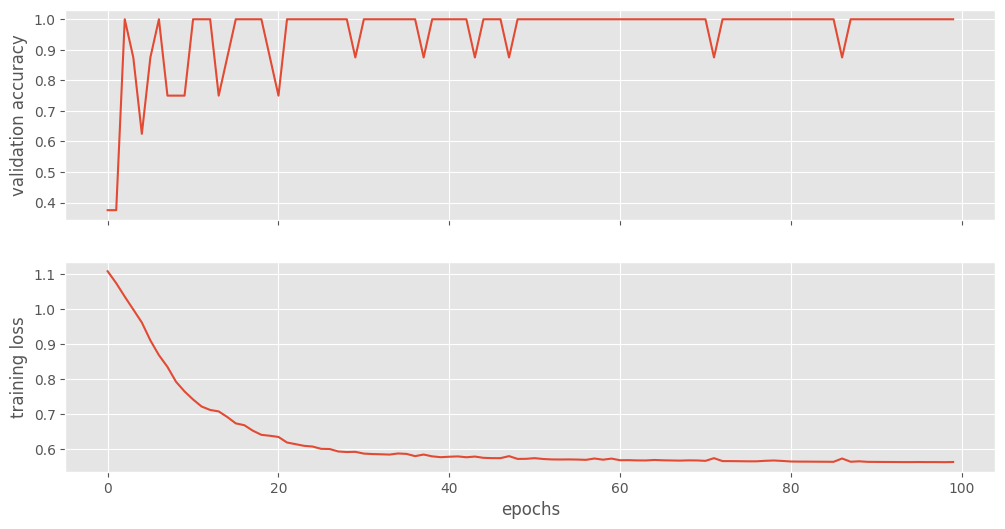

In [52]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("training loss")
ax2.set_xlabel("epochs");


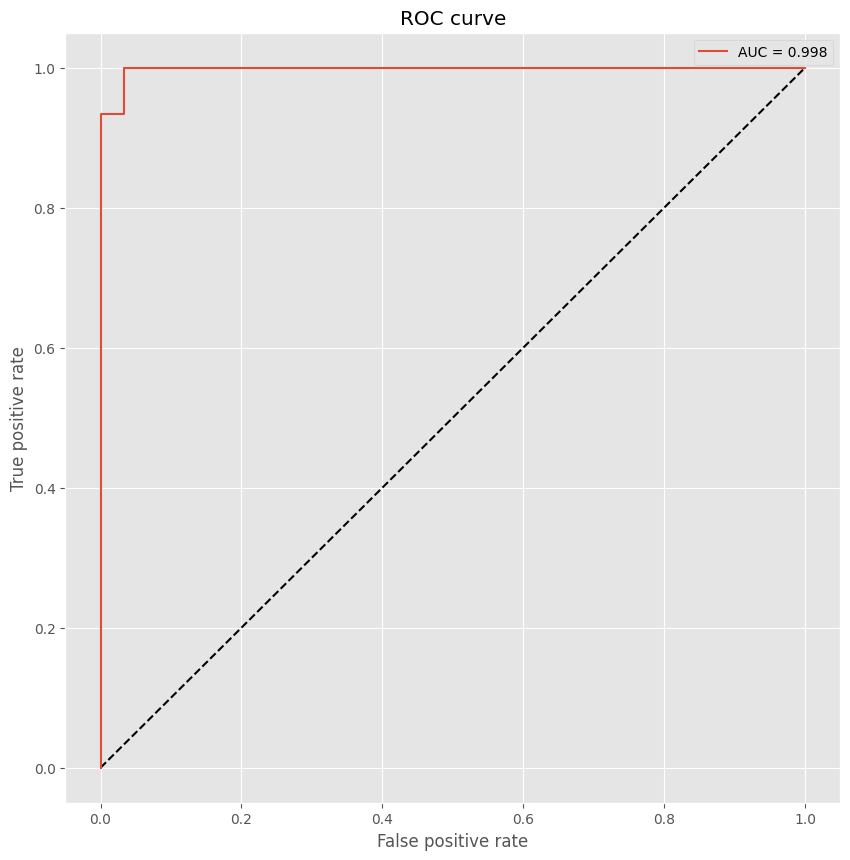

In [59]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

# One hot encoding
enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test.to_numpy()[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(torch.tensor(X_test_scaled).float()).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())

plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();